## Trabalho Final - Ciência de Dados - Enap / 2020

### Apresentação do Dataset

O dataset para a analise apresentada abaixo foi construído pela extração dos dados relativos a imóveis na página www.dfimoveis.com.br. Inicialmente houve uma tentativa de extração do site www.wimoveis.com.br, pois este apresenta uma maior quantidade de imóveis e é o mais utilizado no DF. Porém, a extração não foi possível devido ao captcha que é apresentado quando a conexão é realizada através da biblioteca Selenium.

In [ ]:
# YOUR CODE HERE
# raise NotImplementedError()

#### Link para Download do Dataset

Abaixo é apresentado o código utlizado para fazer o scrapy no site www.dfimoveis.com.br. Não é possível executa-lo diretamente no Jupyter Notebook, pois é necessário a instalação do driver do Firefox localmente. 

O código realiza o scrapy diretamente no resultado da pesquisa, não sendo necessário a visita de cada página de cada imovel individualmente, pois todos os dados que são utilzados nessa análise são apresentados na página de resumo. Ainda assim o acesso foi dividido em lotes de 100 páginas cada para que caso haja problemas na extração, o andamento não seja perdido.

Finalmente o link para o download dos arquivos json utilizados na análise está logo abaixo. Há também um link com a possibilidade de atualização, do repositório. 

In [45]:
#imports
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Biblioteca para plotar gráficos
import seaborn as sns # Biblioteca para plotar gráficos baseada no matplotlib
import time
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By


In [ ]:
## Cole o link do dataset aqui

##Scrapy do dataset: www.dfimoveis.com.br

# O codigo abaixo não deve ser executado no Jupyter Notebook. Deve ser executado no Python localmente. 
# O driver geckodriver do firefox também deve ser instalado

# -*- coding: utf-8 -*-

def wait_element(driver, by_content, by=By.ID, timeout=8, to_sleep=0):
    try:
        element_present = EC.presence_of_element_located((by, by_content))
        WebDriverWait(driver, timeout).until(element_present)
    except TimeoutException:
        print("Timed out waiting for page to load")
        pass
        return False
    if to_sleep > 0:
        time.sleep(to_sleep)
    return True

def get_page_data(driver):
    if 'venda' in driver.find_element_by_xpath('//section/h1').text:
        operacao = 'Venda'
    elif 'alugar' in driver.find_element_by_xpath('//section/h1').text:
        operacao = 'Locacao'
    else: operacao = ''
    a_tags = driver.find_elements_by_xpath('//div[@class="property__info-content"]')
    dataset = []
    for a in range(len(a_tags)):
        cidade = ''
        bairro = ''
        quartos = ''
        suites = ''
        vagas = ''
        situacao = ''
        #Procura por elementos na pagina (não entra no detalhe de cada imovel, 
        #pois a página de resultado da busca tem todas as informações)
        cidade = a_tags[a].find_element_by_tag_name('span').text.split(", ")[1]
        bairro = a_tags[a].find_element_by_tag_name('span').text.split(", ")[0]
        preco = a_tags[a].find_element_by_tag_name('span.price').text.replace('.','')
        if 'A partir' in preco or 'Sob' in preco:
            continue
        tipo_area = a_tags[a].find_elements_by_tag_name('li')
        if tipo_area[0].text == '':
            del (tipo_area[0])
        tipo = tipo_area[0].text.split(" ")[0]
        if len(tipo_area[0].text.split(" ")) > 1:
            if tipo_area[0].text.split(" ")[1].replace('.','').isnumeric():
                area = tipo_area[0].text.split(" ")[1]
            else:
                tipo = tipo + ' ' + tipo_area[0].text.split(" ")[1]
                area = tipo_area[0].text.split(" ")[2]
        else: area = ''
        for b in range(len(tipo_area)):
            if 'uarto' in tipo_area[b].text:
                quartos = tipo_area[b].text.split(" ")[0]
            if 'Suíte' in tipo_area[b].text:
                suites = tipo_area[b].text.split(" ")[0]
            if 'Vaga' in tipo_area[b].text:
                vagas = tipo_area[b].text.split(" ")[0]
            if 'Constr' in tipo_area[b].text or 'Planta' in tipo_area[b].text:
                situacao = tipo_area[b].text.split(" ")[0] + ' ' + tipo_area[b].text.split(" ")[1]
        record = {'operacao': operacao, 'cidade': cidade, 'bairro': bairro, 'preco': preco, 'tipo': tipo, 'area': area,
                  'quartos': quartos, 'suites': suites, 'vagas': vagas, 'situacao': situacao}
        dataset.append(record)
    return dataset


def scrapy_imoveis(url):
    a = 0
    firefox_profile = webdriver.FirefoxProfile()
    #Não permitir imagens para velocidade e tráfego.
    firefox_profile.set_preference("permissions.default.image", 2)
    driver = webdriver.Firefox(firefox_profile)
    driver.get(url)
    to_continue = True
    whole_dataset = []
    while to_continue:
        current_items = get_page_data(driver)
        whole_dataset.extend(current_items)
        try:
            next_button = driver.find_element_by_xpath('//a[@class="pagination__link next"]')
        except NoSuchElementException:
            pass
            break
        next_button.click()
        wait_element(driver, '//footer', by=By.XPATH)
        #Contador para limitar 100 paginas
        if a < 99 :
            to_continue = True
            a = a + 1
        else: to_continue = False
    driver.close()
    return whole_dataset

#Realiza o scrapy e separa os arquivos de venda de 100 em 100 paginas e depois o de aluguel
url = 'https://www.dfimoveis.com.br/venda/df/todos/imoveis?pagina=1'
result = scrapy_imoveis(url)
with open('data_venda1.json', 'w') as fp:
    json.dump(result, fp)

url = 'https://www.dfimoveis.com.br/venda/df/todos/imoveis?pagina=100'
result = scrapy_imoveis(url)
with open('data_venda100.json', 'w') as fp:
    json.dump(result, fp)

url = 'https://www.dfimoveis.com.br/venda/df/todos/imoveis?pagina=200'
result = scrapy_imoveis(url)
with open('data_venda200.json', 'w') as fp:
    json.dump(result, fp)

url = 'https://www.dfimoveis.com.br/venda/df/todos/imoveis?pagina=300'
result = scrapy_imoveis(url)
with open('data_venda300.json', 'w') as fp:
    json.dump(result, fp)

url = 'https://www.dfimoveis.com.br/venda/df/todos/imoveis?pagina=400'
result = scrapy_imoveis(url)
with open('data_venda400.json', 'w') as fp:
    json.dump(result, fp)

url = 'https://www.dfimoveis.com.br/venda/df/todos/imoveis?pagina=500'
result = scrapy_imoveis(url)
with open('data_venda500.json', 'w') as fp:
    json.dump(result, fp)

url = 'https://www.dfimoveis.com.br/venda/df/todos/imoveis?pagina=600'
result = scrapy_imoveis(url)
with open('data_venda600.json', 'w') as fp:
    json.dump(result, fp)

url = 'https://www.dfimoveis.com.br/venda/df/todos/imoveis?pagina=700'
result = scrapy_imoveis(url)
with open('data_venda700.json', 'w') as fp:
    json.dump(result, fp)

url = 'https://www.dfimoveis.com.br/venda/df/todos/imoveis?pagina=800'
result = scrapy_imoveis(url)
with open('data_venda800.json', 'w') as fp:
    json.dump(result, fp)

In [3]:
#!git clone https://github.com/4BR40/trabalho_final_abrao.git ../../curso_ciencia_dados2020/data/originais/imoveis
#!cd ../../curso_ciencia_dados2020/data/originais/imoveis && git pull

Already up to date.


In [7]:
path_aluguel  = '../../curso_ciencia_dados2020/data/originais/imoveis/data_aluguel.json'
path_venda1   = '../../curso_ciencia_dados2020/data/originais/imoveis/data_venda1.json'
path_venda100 = '../../curso_ciencia_dados2020/data/originais/imoveis/data_venda100.json'
path_venda200 = '../../curso_ciencia_dados2020/data/originais/imoveis/data_venda200.json'
path_venda300 = '../../curso_ciencia_dados2020/data/originais/imoveis/data_venda300.json' 
path_venda400 = '../../curso_ciencia_dados2020/data/originais/imoveis/data_venda400.json' 
path_venda500 = '../../curso_ciencia_dados2020/data/originais/imoveis/data_venda500.json' 
path_venda600 = '../../curso_ciencia_dados2020/data/originais/imoveis/data_venda600.json' 
path_venda700 = '../../curso_ciencia_dados2020/data/originais/imoveis/data_venda700.json' 
path_venda800 = '../../curso_ciencia_dados2020/data/originais/imoveis/data_venda800.json' 

aluguel = pd.read_json(path_aluguel)
aluguel


,operacao,cidade,bairro,preco,tipo,area,quartos,suites,vagas,situacao
0,Locacao,Brasilia,Taquari,200000,Predio,5600,,,95,
1,Locacao,Brasilia,Noroeste,5300,Apartamento,91,3,1,2,
2,Locacao,Brasilia,Asa Sul,2600,Apartamento,51,1,,1,
3,Locacao,Brasilia,Sig,35000,Sala,700,,,,
4,Locacao,Brasilia,Jardim Botanico,6000,Casa Condominio,750,6,6,4,
...,...,...,...,...,...,...,...,...,...,...
7732,Locacao,Brasilia,Asa Sul,2000,Sala,11,,,1,
7733,Locacao,Brasilia,Asa Norte,700,Sala,42,,,,
7734,Locacao,Brasilia,Asa Sul,1500,Sala,36,,,1,
7735,Locacao,Taguatinga,Taguatinga Norte,1700,Loja,150,,,,


In [8]:
venda = pd.concat([pd.read_json(path_venda1),  pd.read_json(path_venda100), pd.read_json(path_venda200),
                  pd.read_json(path_venda300), pd.read_json(path_venda400), pd.read_json(path_venda500),
                  pd.read_json(path_venda600), pd.read_json(path_venda700), pd.read_json(path_venda800)]).reset_index()
venda

,index,operacao,cidade,bairro,preco,tipo,area,quartos,suites,vagas,situacao
0,0,Venda,Guara,Guara Ii,365104,Apartamento,52,2,,,Em Construção
1,1,Venda,Taguatinga,Taguatinga Norte,380000,Apartamento,68,3,1,1,
2,2,Venda,Brasilia,Lago Norte,430000,Apartamento,57,1,1,1,
3,3,Venda,Samambaia,Samambaia Sul,189000,Apartamento,48,2,1,1,
4,4,Venda,Guara,Guara Ii,120000,Kitnet,42,1,,1,
...,...,...,...,...,...,...,...,...,...,...,...
25056,1043,Venda,Samambaia,Samambaia Norte,900000,Predio,400,,,,
25057,1044,Venda,Brasilia,Sudoeste,1550000,Apartamento,140,4,2,2,
25058,1045,Venda,Santa Maria,Residencial Santos Dumont,200000,Apartamento,60,2,,1,
25059,1046,Venda,Guara,Guara Ii,135000,Kitnet,30,1,,1,


### Motivação

Com a queda dos juros e conseguente dos custos de financiamento imobiliário, surge a possibildiade de aquisição de imóveis como investimento. Ocorre que, seja para moradia, seja para investimento, a escolha do imóvel não é uma tarefa trivial. Este estudo tem como objetivo traçar uma relação entre os imóveis que estão disponíveis no mercado para compra e os seus respectivos valores de aluguel (imóveis semelhantes, na mesma localização), ou seja apresenta qual a melhor relação custo do imóvel x valor de locação.

In [160]:
# YOUR CODE HERE
# Remove variáveis que não serão utilizadas
vd = venda[['tipo','preco', 'area', 'bairro', 'vagas', 'quartos', 'suites']]
al = aluguel[['tipo','preco', 'area', 'bairro', 'vagas', 'quartos', 'suites']]
# Remove outliers 
vd = vd[vd['preco'] <= 2000000]
al = al[al['preco'] <= 20000]
vd = vd[vd['preco'] > 20000]
al = al[al['preco'] > 300]

# Remove strings vazias (para o join)
al.loc[al['vagas'] == '',['vagas']] = '-'
al.loc[al['quartos'] == '',['quartos']] = '-'
al.loc[al['suites'] == '',['suites']] = '-'
al
# raise NotImplementedError()

,tipo,preco,area,bairro,vagas,quartos,suites
1,Apartamento,5300,91,Noroeste,2,3,1
2,Apartamento,2600,51,Asa Sul,1,1,-
4,Casa Condominio,6000,750,Jardim Botanico,4,6,6
5,Sala,8000,205,Asa Sul,4,-,-
6,Apartamento,11000,401,Asa Sul,2,4,2
...,...,...,...,...,...,...,...
7732,Sala,2000,11,Asa Sul,1,-,-
7733,Sala,700,42,Asa Norte,-,-,-
7734,Sala,1500,36,Asa Sul,1,-,-
7735,Loja,1700,150,Taguatinga Norte,-,-,-


In [161]:
# Remove strings vazias (para o join)
vd.loc[vd['vagas'] == '',['vagas']] = '-'
vd.loc[vd['quartos'] == '',['quartos']] = '-'
vd.loc[vd['suites'] == '',['suites']] = '-'
vd

,tipo,preco,area,bairro,vagas,quartos,suites
0,Apartamento,365104,52,Guara Ii,-,2,-
1,Apartamento,380000,68,Taguatinga Norte,1,3,1
2,Apartamento,430000,57,Lago Norte,1,1,1
3,Apartamento,189000,48,Samambaia Sul,1,2,1
4,Kitnet,120000,42,Guara Ii,1,1,-
...,...,...,...,...,...,...,...
25056,Predio,900000,400,Samambaia Norte,-,-,-
25057,Apartamento,1550000,140,Sudoeste,2,4,2
25058,Apartamento,200000,60,Residencial Santos Dumont,1,2,-
25059,Kitnet,135000,30,Guara Ii,1,1,-


In [162]:
vd["area"] = pd.to_numeric(vd["area"],errors='coerce')
vd.describe()

,preco,area
count,2.213400e+04,2.169900e+04
mean,6.236002e+05,5.876656e+02
std,4.640218e+05,1.858855e+04
min,2.199000e+04,0.000000e+00
25%,2.580000e+05,5.500000e+01
50%,4.700000e+05,1.100000e+02
75%,8.593000e+05,2.750000e+02
max,2.000000e+06,2.500000e+06


In [163]:
al["area"] = pd.to_numeric(al["area"],errors='coerce')
al.describe()

,preco,area
count,7042.000000,7032.000000
mean,2844.905425,108.358362
std,3542.278320,543.832904
min,320.000000,1.000000
25%,950.000000,31.000000
50%,1450.000000,45.000000
75%,2990.000000,81.000000
max,20000.000000,40000.000000


In [164]:
al

,tipo,preco,area,bairro,vagas,quartos,suites
1,Apartamento,5300,91.0,Noroeste,2,3,1
2,Apartamento,2600,51.0,Asa Sul,1,1,-
4,Casa Condominio,6000,750.0,Jardim Botanico,4,6,6
5,Sala,8000,205.0,Asa Sul,4,-,-
6,Apartamento,11000,401.0,Asa Sul,2,4,2
...,...,...,...,...,...,...,...
7732,Sala,2000,11.0,Asa Sul,1,-,-
7733,Sala,700,42.0,Asa Norte,-,-,-
7734,Sala,1500,36.0,Asa Sul,1,-,-
7735,Loja,1700,150.0,Taguatinga Norte,-,-,-


### Investigação

In [ ]:
# YOUR CODE HERE
# raise NotImplementedError()

<function matplotlib.pyplot.show(close=None, block=None)>

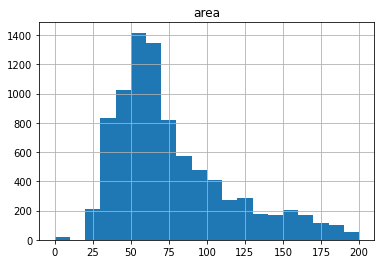

In [167]:
# Histograma para verificar a distribuição das áreas dos Apartamentos a venda.
a = vd.loc[(vd['tipo'] == 'Apartamento') & (vd['area'] <= 200)].hist(column='area', bins=20)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

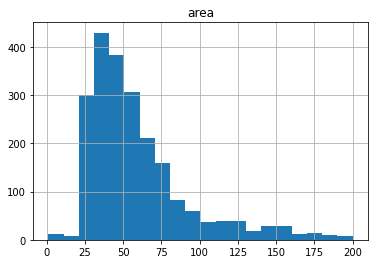

In [168]:
# Histograma para verificar a distribuição das áreas dos Apartamentos para locação.
a = al.loc[(al['tipo'] == 'Apartamento') & (al['area'] <= 200)].hist(column='area', bins=20)
plt.show

<AxesSubplot:xlabel='tipo', ylabel='preco'>

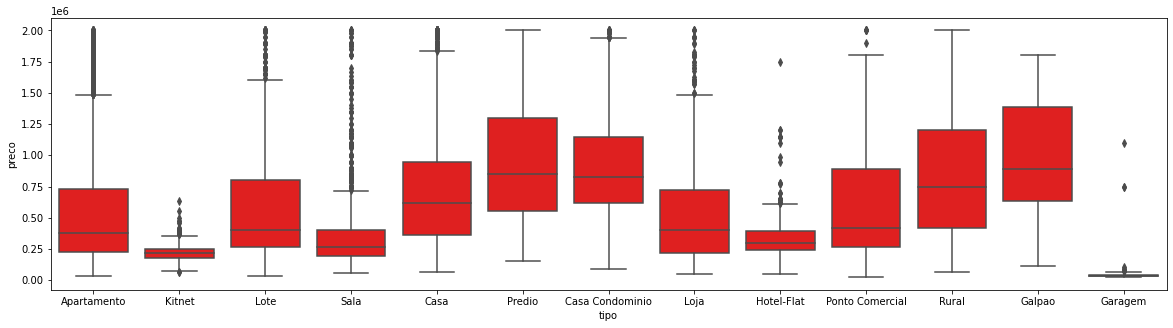

In [169]:
#Boxplot dos valores por tipo de imóvel a venda
plt.figure(figsize=(20,5))
sns.boxplot(
    data=vd,
    x='tipo',
    y='preco',
    color='red')

<AxesSubplot:xlabel='tipo', ylabel='preco'>

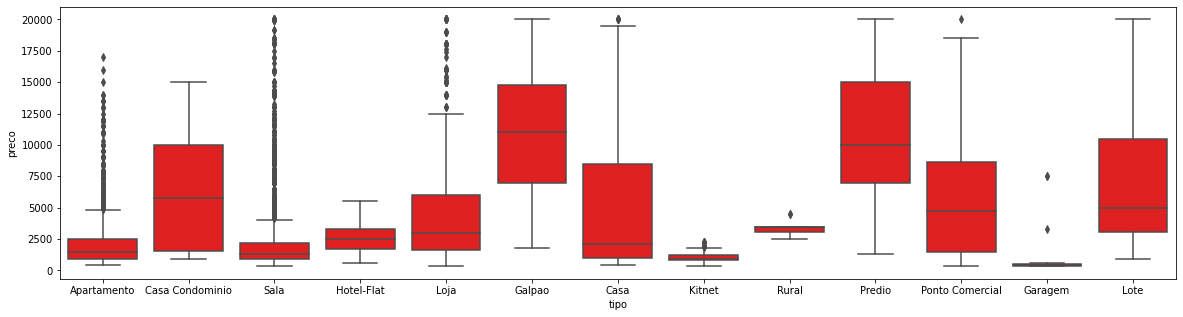

In [170]:
#Boxplot dos valores por tipo de imóvel a locação
plt.figure(figsize=(20,5))
sns.boxplot(
    data=al,
    x='tipo',
    y='preco',
    color='red')

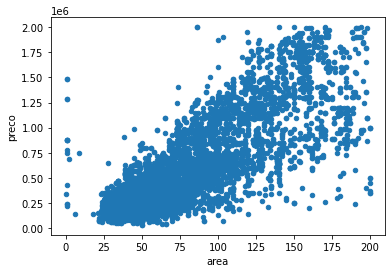

In [171]:
# Cruzamento area x preco dos imoveis a venda
vd.loc[(vd['tipo'] == 'Apartamento') & (vd['area'] <= 200)].plot.scatter(x = 'area', y = 'preco')
plt.show()

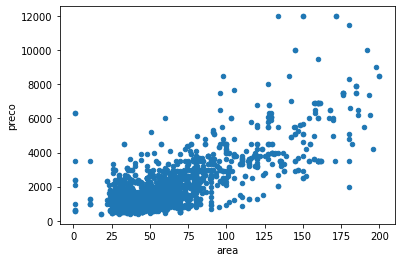

In [172]:
# Cruzamento area x preco dos imoveis a locação
al.loc[(al['tipo'] == 'Apartamento') & (al['area'] <= 200)].plot.scatter(x = 'area', y = 'preco')
plt.show()

In [173]:
#Aplica uma função para classificar as áreas em faixas de 10 em 10 metros quadrados.
vd['area_range'] = vd['area'].map(lambda x: x//10)

al['area_range'] = al['area'].map(lambda x: x//10)

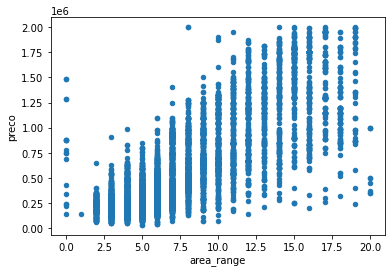

In [174]:
# Cruzamento range de area x preco dos imoveis a venda
vd.loc[(vd['tipo'] == 'Apartamento') & (vd['area'] <= 200)].plot.scatter(x = 'area_range', y = 'preco')
plt.show()

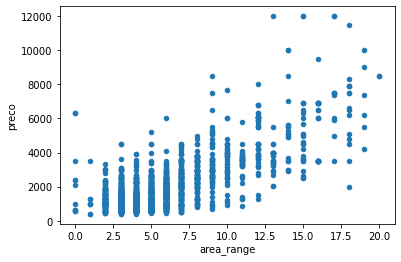

In [175]:
# Cruzamento range de area x preco dos imoveis a locação
al.loc[(al['tipo'] == 'Apartamento') & (al['area'] <= 200)].plot.scatter(x = 'area_range', y = 'preco')
plt.show()

In [176]:
#Agrupa pelas características analisadas
vd_agg = vd[['tipo','bairro','area_range','quartos','suites','vagas','preco']].groupby(['tipo','bairro','area_range','quartos','suites','vagas']).agg([('mean_vd', 'mean'),('median_vd', 'median'),('std_vd', 'std'),('qt_vd', 'count') ] )
vd_agg

preco  \
                                                             mean_vd   
tipo        bairro         area_range quartos suites vagas             
Apartamento Ade            2.0        1       -      -       90000.0   
                           3.0        1       -      -       76250.0   
                           4.0        1       -      -       99000.0   
                           5.0        2       -      -      135000.0   
                           11.0       2       1      -      190000.0   
...                                                              ...   
Sala        Taguatinga Sul 8.0        -       -      -      250000.0   
            Velho          2.0        -       -      -      118000.0   
            Vicente Pires  3.0        -       -      -      150000.0   
                           5.0        2       -      1      170000.0   
                           7.0        -       -      -      310000.0   

                                                                      \
                                                           median_vd   
tipo        bairro         area_range quartos suites vagas             
Apartamento Ade            2.0        1       -      -       90000.0   
                           3.0        1       -      -       75000.0   
                           4.0        1       -      -       99000.0   
                           5.0        2       -      -      135000.0   
                           11.0       2       1      -      190000.0   
...                                                              ...   
Sala        Taguatinga Sul 8.0        -       -      -      250000.0   
            Velho          2.0        -       -      -      118000.0   
            Vicente Pires  3.0        -       -      -      150000.0   
                           5.0        2       -      1      170000.0   
                           7.0        -       -      -      310000.0   

                                                                                
                                                                  std_vd qt_vd  
tipo        bairro         area_range quartos suites vagas                      
Apartamento Ade            2.0        1       -      -          0.000000     2  
                           3.0        1       -      -      16520.189668     4  
                           4.0        1       -      -               NaN     1  
                           5.0        2       -      -               NaN     1  
                           11.0       2       1      -          0.000000     2  
...                                                                  ...   ...  
Sala        Taguatinga Sul 8.0        -       -      -          0.000000     2  
            Velho          2.0        -       -      -               NaN     1  
            Vicente Pires  3.0        -       -      -          0.000000     2  
                           5.0        2       -      1          0.000000     2  
                           7.0        -       -      -               NaN     1  

[9239 rows x 4 columns]

In [177]:
#Agrupa pelas características analisadas
al_agg = al[['tipo','bairro','area_range','quartos','suites','vagas','preco']].groupby(['tipo','bairro','area_range','quartos','suites','vagas']).agg([('mean_al', 'mean'),('median_al', 'median'),('std_al', 'std'),('qt_al', 'count') ] )
al_agg

preco  \
                                                                       mean_al   
tipo        bairro                     area_range quartos suites vagas           
Apartamento Ade                        1.0        1       -      -       400.0   
                                       4.0        1       -      -       600.0   
                                       5.0        2       -      -       800.0   
                                                          1      -      1200.0   
                                                  3       1      -      1000.0   
...                                                                        ...   
Sala        Vicente Pires              2.0        -       -      -       600.0   
                                       3.0        -       -      -       750.0   
                                       7.0        -       -      -      2000.0   
                                       25.0       -       -      -      6400.0   
            Zona Civico Administrativa 4.0        -       -      1      1900.0   

                                                                                  \
                                                                       median_al   
tipo        bairro                     area_range quartos suites vagas             
Apartamento Ade                        1.0        1       -      -         400.0   
                                       4.0        1       -      -         600.0   
                                       5.0        2       -      -         800.0   
                                                          1      -        1200.0   
                                                  3       1      -        1000.0   
...                                                                          ...   
Sala        Vicente Pires              2.0        -       -      -         600.0   
                                       3.0        -       -      -         750.0   
                                       7.0        -       -      -        2000.0   
                                       25.0       -       -      -        6400.0   
            Zona Civico Administrativa 4.0        -       -      1        1900.0   

                                                                               \
                                                                       std_al   
tipo        bairro                     area_range quartos suites vagas          
Apartamento Ade                        1.0        1       -      -        0.0   
                                       4.0        1       -      -        NaN   
                                       5.0        2       -      -        0.0   
                                                          1      -        NaN   
                                                  3       1      -        NaN   
...                                                                       ...   
Sala        Vicente Pires              2.0        -       -      -        0.0   
                                       3.0        -       -      -        0.0   
                                       7.0        -       -      -        0.0   
                                       25.0       -       -      -        0.0   
            Zona Civico Administrativa 4.0        -       -      1        NaN   

                                                                              
                                                                       qt_al  
tipo        bairro                     area_range quartos suites vagas        
Apartamento Ade                        1.0        1       -      -         2  
                                       4.0        1       -      -         1  
                                       5.0        2       -      -         2  
                                                          1      -         1  
                                                  3       1

### Conclusões e Achados

A tabela abaixo apresenta a razão dos valores médios de venda em relação ao preço cobrado pelo aluguel. Para uma análise mais completa, faz se necessário a obtenção de uma base de dados com mais registros e uma série histórica. A presente análise somente levou em consideração o retrato de um único website em uma única data. 

Quanto maior o valor da razão, teoricamente é melhor o retorno do investimento no valor do aluguel. Quantidades pequenas de imóveis anunciados em cada categoria deve ser descartada.

In [180]:
df = vd_agg.merge(al_agg, on=['tipo','bairro','area_range','quartos','suites','vagas'])
df
df['razao'] = df['preco']['mean_al']/df['preco']['mean_vd']
df.sort_values(['razao'], ascending=[ False])


preco  \
                                                                   mean_vd   
tipo bairro                     area_range quartos suites vagas              
Loja Asa Sul                    28.0       -       -      -       380000.0   
     Vicente Pires              7.0        -       -      -       150000.0   
                                30.0       -       -      -       370000.0   
     Nova Colina                3.0        -       -      -        50000.0   
Sala Asa Sul                    3.0        1       -      -        75000.0   
...                                                                    ...   
Casa Taguatinga Norte           5.0        1       -      -       345000.0   
Loja Taguatinga Norte           4.0        -       -      -       688000.0   
     Asa Norte                  21.0       -       -      -      1800000.0   
Sala Sig                        4.0        -       -      -       644800.0   
Lote Colonia Agricola Samambaia 80.0       -       -      -       950000.0   

                                                                            \
                                                                 median_vd   
tipo bairro                     area_range quartos suites vagas              
Loja Asa Sul                    28.0       -       -      -       380000.0   
     Vicente Pires              7.0        -       -      -       150000.0   
                                30.0       -       -      -       370000.0   
     Nova Colina                3.0        -       -      -        50000.0   
Sala Asa Sul                    3.0        1       -      -        75000.0   
...                                                                    ...   
Casa Taguatinga Norte           5.0        1       -      -       345000.0   
Loja Taguatinga Norte           4.0        -       -      -       688000.0   
     Asa Norte                  21.0       -       -      -      1800000.0   
Sala Sig                        4.0        -       -      -       430000.0   
Lote Colonia Agricola Samambaia 80.0       -       -      -       950000.0   

                                                                                \
                                                                        std_vd   
tipo bairro                     area_range quartos suites vagas                  
Loja Asa Sul                    28.0       -       -      -                NaN   
     Vicente Pires              7.0        -       -      -                NaN   
                                30.0       -       -      -                NaN   
     Nova Colina                3.0        -       -      -                NaN   
Sala Asa Sul                    3.0        1       -      -                NaN   
...                                                                        ...   
Casa Taguatinga Norte           5.0        1       -      -      219203.102168   
Loja Taguatinga Norte           4.0        -       -      -                NaN   
     Asa Norte                  21.0       -       -      -                NaN   
Sala Sig                        4.0        -       -      -      508778.144185   
Lote Colonia Agricola Samambaia 80.0       -       -      -                NaN   

                                                                       \
                                                                qt_vd   
tipo bairro                     area_range quartos suites vagas         
Loja Asa Sul                    28.0       -       -      -         1   
     Vicente Pires              7.0        -       -      -         1   
                                30.0       -       -      -         1   
     Nova Colina                3.0        -       -      -         1   
Sala Asa Sul                    3.0        1       -      -         1   
...                                                               ...   
Casa Taguatinga Norte           5.0        1       -      -         2   
Loja